In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, SubsetRandomSampler, DataLoader,Subset
from torch.optim import Adam

from collections import Counter
import itertools

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [2]:
# Use GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# CONSTANTS
DATASET_DIR = 'data/'
NUM_CLASSES = 12
BATCH_SIZE = 32
NUM_FOLDS = 2
LEARNING_RATE = 0.001
NUM_EPOCHS = 1
LOSS_FN = nn.CrossEntropyLoss()

cuda


In [3]:
transformations = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])
dataset = ImageFolder(DATASET_DIR, transform = transformations)
CLASSES = dataset.class_to_idx.keys()
print('total dataset',len(dataset))
print(dataset.class_to_idx)

total dataset 15515
{'battery': 0, 'biological': 1, 'brown-glass': 2, 'cardboard': 3, 'clothes': 4, 'green-glass': 5, 'metal': 6, 'paper': 7, 'plastic': 8, 'shoes': 9, 'trash': 10, 'white-glass': 11}


In [4]:
def imshow(image):
    plt.imshow(image[0].permute(1, 2, 0))
    print(f'Image sampled from class {image[1]} - "{dataset.classes[image[1]]}"')

In [5]:
all_idxs = np.arange(len(dataset))
train_idxs, test_idxs = train_test_split(all_idxs, test_size=0.3,stratify=dataset.targets, random_state=0)
train_labels = np.array(dataset.targets)[train_idxs]
test_labels = np.array(dataset.targets)[test_idxs]
print('train dataset',len(train_idxs))
print('test dataset',len(test_idxs))

train dataset 10860
test dataset 4655


In [6]:
print(Counter(train_labels))
print(Counter(test_labels))

Counter({4: 3727, 9: 1384, 7: 735, 1: 689, 0: 661, 3: 624, 8: 606, 11: 543, 6: 538, 10: 488, 5: 440, 2: 425})
Counter({4: 1598, 9: 593, 7: 315, 1: 296, 0: 284, 3: 267, 8: 259, 11: 232, 6: 231, 10: 209, 5: 189, 2: 182})


In [7]:
class GarbageDetectorCNN(nn.Module):
    def __init__(self, kernel_size=5, padding=1):
        super(GarbageDetectorCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=kernel_size, padding=padding)
        self.act1 = nn.Hardtanh(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=kernel_size, padding=padding)
        self.act2 = nn.Hardtanh(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(14 * 14 * 32, 512)
        self.act3 = nn.ReLU(inplace=True)
        self.fc3 = nn.Linear(512, NUM_CLASSES)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))

        out = out.view(out.size(0), -1)  # Flatten

        out = self.act3(self.fc1(out))
        out = self.fc3(out)

        return out

In [8]:
def evaluation_metrics(loader):
    model.to('cpu')
    model.eval()
    all_predicted = torch.tensor([])
    all_labels = torch.tensor([])

    for images, labels in loader:
        preds = model(images)
        predicted = torch.argmax(preds.data, axis=1)
        all_labels = torch.cat((all_labels, labels))
        all_predicted = torch.cat((all_predicted, predicted))

    # plot_confusion(all_labels, all_predicted)

    accuracy = accuracy_score(all_labels, all_predicted) * 100
    f1 = f1_score(all_labels, all_predicted, average='macro')
    recall = recall_score(all_labels, all_predicted, average='macro')
    precision = precision_score(all_labels, all_predicted, average='macro')
    conf_matrix = confusion_matrix(all_labels, all_predicted)
    return conf_matrix,[accuracy, f1, recall, precision]

In [9]:
def plot_cm(cm, classes, normalize=False, title='Visualization of the confusion matrix', cmap=plt.cm.Reds):
    plt.figure(figsize=(14,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    
    plt.ylabel('Actual True label')
    plt.xlabel('Predicted label')

In [10]:
def train_and_save(train_loader, optimizer, total_step):
    for epoch in range(NUM_EPOCHS):
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = LOSS_FN(outputs, labels)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Training Progress
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()

            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, NUM_EPOCHS, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

    torch.save(model.state_dict(), "./model.pth")

In [11]:
total_scores = []
total_confusion_matrix = np.zeros((NUM_CLASSES,NUM_CLASSES))
kf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True)

for train_index, test_index in kf.split(train_idxs,train_labels):
    model = GarbageDetectorCNN()
    model.to(device)

    train_fold = Subset(dataset, train_idxs[train_index])
    test_fold = Subset(dataset, train_idxs[test_index])

    train_loader = DataLoader(train_fold, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_fold, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
    total_step = len(train_loader)
    train_and_save(train_loader, optimizer, total_step)
    # Evaluation
    conf_matrix, scores = evaluation_metrics(test_loader)

    total_scores.append(scores)
    total_confusion_matrix = np.add(total_confusion_matrix,conf_matrix)

scores_df = pd.DataFrame(total_scores,columns=['accuracy', 'f1', 'recall', 'precision'])

Epoch [1/1], Step [1/169], Loss: 2.5062, Accuracy: 3.12%
Epoch [1/1], Step [2/169], Loss: 2.3476, Accuracy: 43.75%
Epoch [1/1], Step [3/169], Loss: 2.2866, Accuracy: 37.50%
Epoch [1/1], Step [4/169], Loss: 2.4981, Accuracy: 18.75%
Epoch [1/1], Step [5/169], Loss: 2.3002, Accuracy: 37.50%
Epoch [1/1], Step [6/169], Loss: 2.2390, Accuracy: 34.38%
Epoch [1/1], Step [7/169], Loss: 2.2708, Accuracy: 25.00%
Epoch [1/1], Step [8/169], Loss: 1.9191, Accuracy: 37.50%
Epoch [1/1], Step [9/169], Loss: 1.8564, Accuracy: 37.50%
Epoch [1/1], Step [10/169], Loss: 2.0492, Accuracy: 31.25%
Epoch [1/1], Step [11/169], Loss: 1.8874, Accuracy: 40.62%
Epoch [1/1], Step [12/169], Loss: 2.0123, Accuracy: 34.38%
Epoch [1/1], Step [13/169], Loss: 1.9987, Accuracy: 34.38%
Epoch [1/1], Step [14/169], Loss: 1.8914, Accuracy: 50.00%
Epoch [1/1], Step [15/169], Loss: 1.5971, Accuracy: 50.00%
Epoch [1/1], Step [16/169], Loss: 1.7740, Accuracy: 43.75%
Epoch [1/1], Step [17/169], Loss: 1.3670, Accuracy: 71.88%
Epoch [

Epoch [1/1], Step [142/169], Loss: 1.3056, Accuracy: 59.38%
Epoch [1/1], Step [143/169], Loss: 1.1322, Accuracy: 65.62%
Epoch [1/1], Step [144/169], Loss: 1.3672, Accuracy: 50.00%
Epoch [1/1], Step [145/169], Loss: 1.0686, Accuracy: 56.25%
Epoch [1/1], Step [146/169], Loss: 0.8397, Accuracy: 75.00%
Epoch [1/1], Step [147/169], Loss: 1.2139, Accuracy: 53.12%
Epoch [1/1], Step [148/169], Loss: 1.5305, Accuracy: 43.75%
Epoch [1/1], Step [149/169], Loss: 1.4454, Accuracy: 53.12%
Epoch [1/1], Step [150/169], Loss: 1.1286, Accuracy: 62.50%
Epoch [1/1], Step [151/169], Loss: 1.3380, Accuracy: 50.00%
Epoch [1/1], Step [152/169], Loss: 1.0535, Accuracy: 75.00%
Epoch [1/1], Step [153/169], Loss: 0.9684, Accuracy: 71.88%
Epoch [1/1], Step [154/169], Loss: 1.2473, Accuracy: 56.25%
Epoch [1/1], Step [155/169], Loss: 1.1929, Accuracy: 75.00%
Epoch [1/1], Step [156/169], Loss: 1.3382, Accuracy: 53.12%
Epoch [1/1], Step [157/169], Loss: 1.0448, Accuracy: 62.50%
Epoch [1/1], Step [158/169], Loss: 1.242

Epoch [1/1], Step [112/169], Loss: 1.4169, Accuracy: 50.00%
Epoch [1/1], Step [113/169], Loss: 1.5192, Accuracy: 56.25%
Epoch [1/1], Step [114/169], Loss: 1.1677, Accuracy: 56.25%
Epoch [1/1], Step [115/169], Loss: 1.5502, Accuracy: 46.88%
Epoch [1/1], Step [116/169], Loss: 1.4992, Accuracy: 37.50%
Epoch [1/1], Step [117/169], Loss: 1.2019, Accuracy: 62.50%
Epoch [1/1], Step [118/169], Loss: 1.2004, Accuracy: 62.50%
Epoch [1/1], Step [119/169], Loss: 1.2631, Accuracy: 59.38%
Epoch [1/1], Step [120/169], Loss: 1.2150, Accuracy: 53.12%
Epoch [1/1], Step [121/169], Loss: 1.4877, Accuracy: 53.12%
Epoch [1/1], Step [122/169], Loss: 1.3764, Accuracy: 43.75%
Epoch [1/1], Step [123/169], Loss: 1.3637, Accuracy: 50.00%
Epoch [1/1], Step [124/169], Loss: 1.4408, Accuracy: 43.75%
Epoch [1/1], Step [125/169], Loss: 1.3927, Accuracy: 40.62%
Epoch [1/1], Step [126/169], Loss: 1.0546, Accuracy: 59.38%
Epoch [1/1], Step [127/169], Loss: 1.0444, Accuracy: 65.62%
Epoch [1/1], Step [128/169], Loss: 0.860

Confusion matrix, without normalization


accuracy     56.231509
f1            0.443320
recall        0.456150
precision     0.526611
dtype: float64

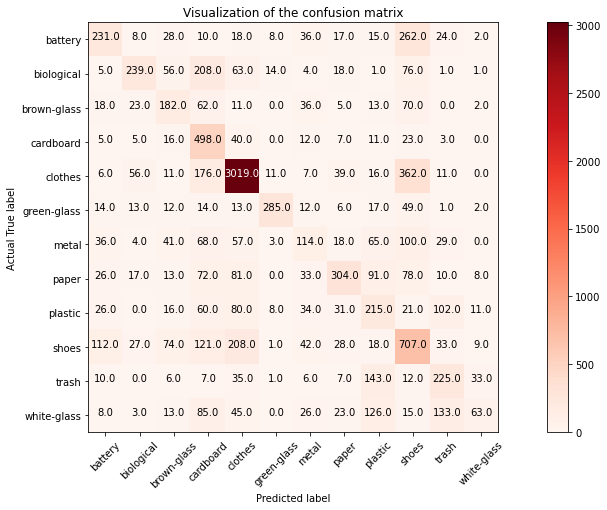

In [12]:
plot_cm(total_confusion_matrix, CLASSES)
scores_df.mean()